In [1]:
import os
import zarr
import random
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


class CFG:
    particles_name = [
        "apo-ferritin",
        "beta-amylase",
        "beta-galactosidase",
        "ribosome",
        "thyroglobulin",
        "virus-like-particle",
    ]

    resolution2ratio = {
        "A": 1 / 10,
        "0": 1,
        "1": 2,
        "2": 4,
    }

    particles2cls = {
        "none": 0,
        "apo-ferritin": 1,
        "beta-amylase": 2,
        "beta-galactosidase": 3,
        "ribosome": 4,
        "thyroglobulin": 5,
        "virus-like-particle": 6,
    }
    cls2particles = {
        0: "none",
        1: "apo-ferritin",
        2: "beta-amylase",
        3: "beta-galactosidase",
        4: "ribosome",
        5: "thyroglobulin",
        6: "virus-like-particle",
    }

    particle_radius = {
        "apo-ferritin": 60,
        "beta-amylase": 65,
        "beta-galactosidase": 90,
        "ribosome": 150,
        "thyroglobulin": 130,
        "virus-like-particle": 135,
    }

    particle_weights = {
        "apo-ferritin": 1,
        "beta-amylase": 0,
        "beta-galactosidase": 2,
        "ribosome": 1,
        "thyroglobulin": 2,
        "virus-like-particle": 1,
    }

    colormap = {
        # -1の場合は透明の色
    }


def read_zarr(zarr_pth, resolution="0"):
    zarr_store = zarr.open(zarr_pth, mode="r")

    tomogram = zarr_store[resolution][:]

    return tomogram


def read_info_json(
    base_dir="../inputs/train/overlay/ExperimentRuns/",
    exp_name="TS_5_4",
    particle_name="apo-ferritin",
):

    keys = set(
        [
            "apo-ferritin",
            "beta-amylase",
            "beta-galactosidase",
            "ribosome",
            "thyroglobulin",
            "virus-like-particle",
        ]
    )

    if particle_name not in keys:
        raise ValueError(
            f"Particle name should be one of the following: {keys}. Got {particle_name}."
        )

    read_json_path = os.path.join(base_dir, exp_name, "Picks", f"{particle_name}.json")

    with open(read_json_path, "r") as f:
        particle_info = json.load(f)

    coords = []
    for point in particle_info["points"]:
        coords.append(
            [point["location"]["z"], point["location"]["y"], point["location"]["x"]]
        )

    coords = np.array(coords)

    return coords


def scale_coordinates(coords, tomogram_shape, resolution):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()

    # scaled_coords[:, 0] = coords[:, 0] / 10  # / coords[:, 0].max() * tomogram_shape[0]
    # scaled_coords[:, 1] = coords[:, 1] / 10  # / coords[:, 1].max() * tomogram_shape[1]
    # scaled_coords[:, 2] = coords[:, 2] / 10  # / coords[:, 2].max() * tomogram_shape[2]

    resolution_info = CFG.resolution2ratio
    scaled_coords[:, 0] = (
        coords[:, 0] * resolution_info["A"] / resolution_info[resolution]
    )
    scaled_coords[:, 1] = (
        coords[:, 1] * resolution_info["A"] / resolution_info[resolution]
    )
    scaled_coords[:, 2] = (
        coords[:, 2] * resolution_info["A"] / resolution_info[resolution]
    )

    return scaled_coords


def create_dataset(
    zarr_type="ctfdeconvolved",
    base_dir="../../inputs/train/",
    exp_name="TS_5_4",
    resolution="0",
    particle_names=[],
):
    zarr_name = f"{zarr_type}.zarr"
    zarr_pth = os.path.join(
        base_dir, "static/ExperimentRuns", exp_name, "VoxelSpacing10.000/", zarr_name
    )
    tomogram = read_zarr(zarr_pth, resolution=resolution)

    particle_info = {"corrds": {}, "scaled_corrds": {}}
    for particle_name in particle_names:
        coords = read_info_json(
            os.path.join(base_dir, "overlay/ExperimentRuns/"), exp_name, particle_name
        )
        scaled_coords = scale_coordinates(coords, tomogram.shape, resolution)
        particle_info["corrds"][particle_name] = coords
        particle_info["scaled_corrds"][particle_name] = scaled_coords

    return tomogram, particle_info


def normalise_by_percentile(data, min=5, max=99):
    min = np.percentile(data, min)
    max = np.percentile(data, max)
    data = (data - min) / (max - min)
    return data, min, max


class EziiDataset(Dataset):
    def __init__(
        self,
        exp_names=[],
        base_dir="../../inputs/train/static",
        particles_name=CFG.particles_name,
        resolution="0",
        zarr_type=["ctfdeconvolved"],
    ):
        self.exp_names = exp_names
        self.base_dir = base_dir
        self.particles_name = particles_name
        self.resolution = resolution
        self.zarr_type = zarr_type

        # exp_namesとzarr_typeの総当たりでデータを作成
        self.data = []
        for exp_name in exp_names:
            for type_ in zarr_type:
                self.data.append((exp_name, type_))

        print(self.data)

    def __getitem__(self, i):
        exp_name, type_ = self.data[i]  # TS_6_6

        tomogram, particle_info = create_dataset(
            particle_names=self.particles_name,
            resolution=self.resolution,
            exp_name=exp_name,
            zarr_type=type_,
        )

        normalized_tomogram, min, max = normalise_by_percentile(tomogram)
        apo_ferritin = particle_info["scaled_corrds"]["apo-ferritin"]
        beta_amylase = particle_info["scaled_corrds"]["beta-amylase"]
        beta_galactosidase = particle_info["scaled_corrds"]["beta-galactosidase"]
        ribosome = particle_info["scaled_corrds"]["ribosome"]
        thyroglobulin = particle_info["scaled_corrds"]["thyroglobulin"]
        virus_like_particle = particle_info["scaled_corrds"]["virus-like-particle"]

        prticle_corrds = {
            "apo-ferritin": apo_ferritin,
            "beta-amylase": beta_amylase,
            "beta-galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus-like-particle": virus_like_particle,
        }

        segmentation_map = create_segmentation_map(
            tomogram, resolution=self.resolution, particle_coords=prticle_corrds
        )

        tomogram = padding(tomogram, self.resolution)
        normalized_tomogram = padding(normalized_tomogram, self.resolution)
        segmentation_map = padding(segmentation_map, self.resolution)

        return {
            "resolution": self.resolution,
            "exp_name": exp_name,
            "tomogram": tomogram,
            "normalized_tomogram": normalized_tomogram,
            "segmentation_map": segmentation_map,
            "apo_ferritin": apo_ferritin,
            "beta_amylase": beta_amylase,
            "beta_galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus_like_particle": virus_like_particle,
            "particle_corrds": prticle_corrds,
        }

    def __len__(self):
        return len(self.data)


def padding(tomogram, resolution):
    if resolution == "0":  # 184, 630, 630 -> 184, 640, 640
        tomogram = np.pad(tomogram, ((0, 0), (5, 5), (5, 5)), mode="constant")
        return tomogram
    elif resolution == "1":  # 92, 315, 315 -> 92, 320, 320
        tomogram = np.pad(tomogram, ((0, 0), (2, 2), (2, 2)), mode="constant")
        return tomogram
    elif resolution == "2":  # 46, 158, 158 -> 46, 160, 160
        tomogram = np.pad(tomogram, ((0, 0), (1, 1), (1, 1)), mode="constant")
        return tomogram
    raise ValueError(
        f"Resolution should be one of the following: 0, 1, 2. Got {resolution}."
    )


def create_segmentation_map(tomogram, resolution, particle_coords={}):
    segmentation_map = np.zeros_like(tomogram)
    segmentation_map[:, :, :] = 0

    particle_radius = (
        CFG.particle_radius
    )  # {apo-ferritin: 60, beta-amylase: 65, beta-galactosidase: 90, ribosome: 150, thyroglobulin: 130, virus-like-particle: 135}
    particle2cls = CFG.particles2cls
    resolution_info = CFG.resolution2ratio  # {A: 1/10, 0: 1, 1: 2, 2: 4}

    r_by_particle = {}
    for particle_name, r in particle_radius.items():
        r_by_particle[particle_name] = (
            r * resolution_info["A"] / resolution_info[resolution]
        )

    for i, (paraticle_name, coords) in enumerate(particle_coords.items()):
        # print(coords.shape)
        for z, y, x in coords:
            z, y, x = int(z), int(y), int(x)
            cls = particle2cls[paraticle_name]
            r = r_by_particle[paraticle_name]
            z_min = int(max(0, z - r))
            z_max = int(min(tomogram.shape[0], z + r))
            y_min = int(max(0, y - r))
            y_max = int(min(tomogram.shape[1], y + r))
            x_min = int(max(0, x - r))
            x_max = int(min(tomogram.shape[2], x + r))

            # x,y,zを中心に円計上にクラスを埋める
            # segmentation_map[z_min:z_max, y_min:y_max, x_min:x_max] = cls
            for z_ in range(z_min, z_max):
                for y_ in range(y_min, y_max):
                    for x_ in range(x_min, x_max):
                        if (z - z_) ** 2 + (y - y_) ** 2 + (x - x_) ** 2 < r**2:
                            segmentation_map[z_, y_, x_] = cls

    return segmentation_map

[('TS_5_4', 'ctfdeconvolved')]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


903077

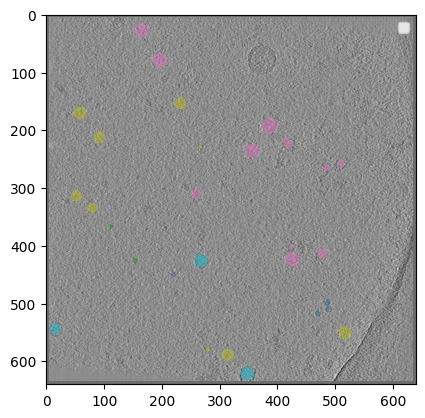

In [2]:
dataset = EziiDataset(
    exp_names=["TS_5_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 100
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)
plt.legend()

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

[('TS_6_4', 'ctfdeconvolved')]


182877

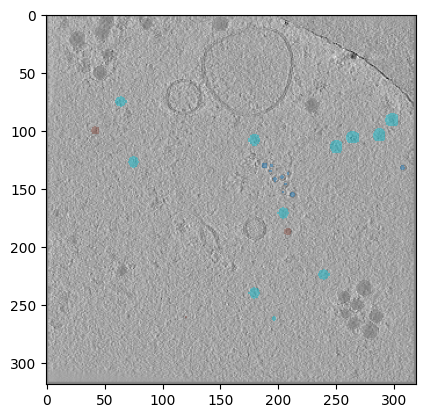

In [3]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="1",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 25
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

In [4]:
import torch
import torch.nn as nn
from icecream import ic
import segmentation_models_pytorch as smp


class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = smp.Unet(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=len(CFG.particles2cls),
        )

    def forward(self, x):

        x = self.model(x)

        return x

In [5]:
train_dataset = EziiDataset(
    exp_names=["TS_5_4", "TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
    # zarr_type=["ctfdeconvolved"],
    zarr_type=["denoised", "ctfdeconvolved", "wbp", "isonetcorrected"],
)

valid_dataset = EziiDataset(
    exp_names=["TS_86_3", "TS_6_6"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
    # zarr_type=["ctfdeconvolved"],
    zarr_type=["denoised"],
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_5_4', 'ctfdeconvolved'), ('TS_5_4', 'wbp'), ('TS_5_4', 'isonetcorrected'), ('TS_73_6', 'denoised'), ('TS_73_6', 'ctfdeconvolved'), ('TS_73_6', 'wbp'), ('TS_73_6', 'isonetcorrected'), ('TS_99_9', 'denoised'), ('TS_99_9', 'ctfdeconvolved'), ('TS_99_9', 'wbp'), ('TS_99_9', 'isonetcorrected'), ('TS_6_4', 'denoised'), ('TS_6_4', 'ctfdeconvolved'), ('TS_6_4', 'wbp'), ('TS_6_4', 'isonetcorrected'), ('TS_69_2', 'denoised'), ('TS_69_2', 'ctfdeconvolved'), ('TS_69_2', 'wbp'), ('TS_69_2', 'isonetcorrected')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/20 [00:00<?, ?it/s]


46

Valid-Epoch: 0, Loss: 1.2891312267469324: 100%|██████████| 92/92 [00:03<00:00, 28.37it/s]


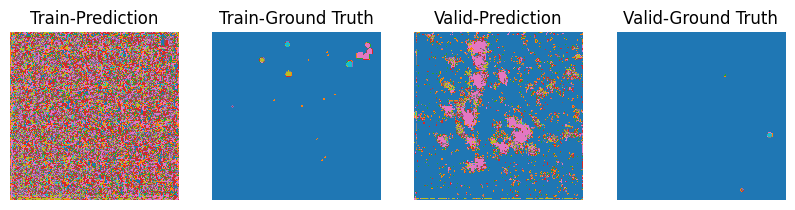

Epoch: 0, Loss: 1.1638166904449463


Valid-Epoch: 1, Loss: 0.9651135245095128: 100%|██████████| 92/92 [00:03<00:00, 26.92it/s]


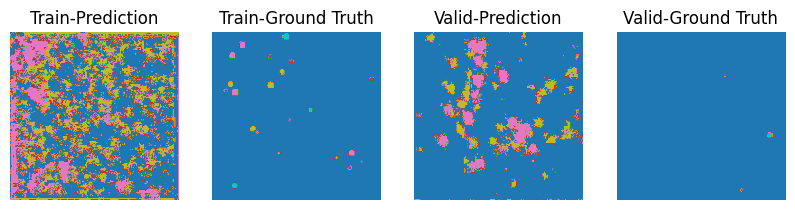

Epoch: 1, Loss: 0.703752875328064


Valid-Epoch: 2, Loss: 0.7468832770119542: 100%|██████████| 92/92 [00:03<00:00, 29.37it/s]


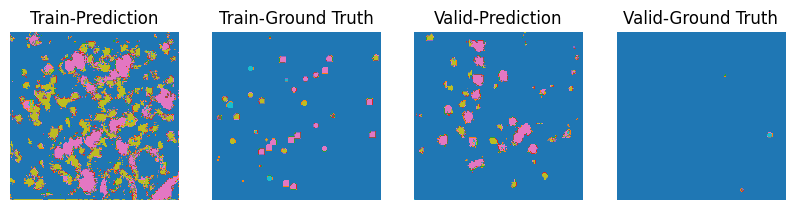

Epoch: 2, Loss: 0.425587922334671


Valid-Epoch: 3, Loss: 0.6059796285370121: 100%|██████████| 92/92 [00:03<00:00, 28.66it/s]


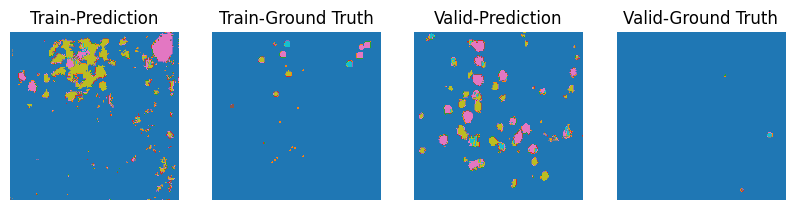

Epoch: 3, Loss: 0.28011173009872437


Valid-Epoch: 4, Loss: 0.6097291821370954: 100%|██████████| 92/92 [00:03<00:00, 29.07it/s]


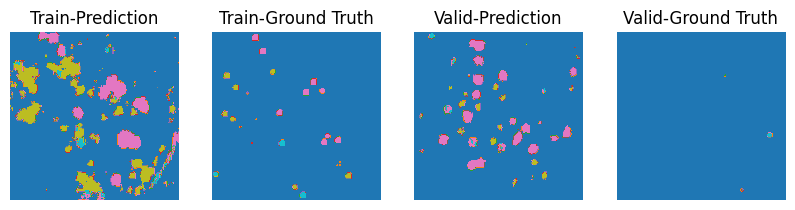

Epoch: 4, Loss: 0.19409038126468658


Valid-Epoch: 5, Loss: 0.5482145267660203: 100%|██████████| 92/92 [00:03<00:00, 29.70it/s]


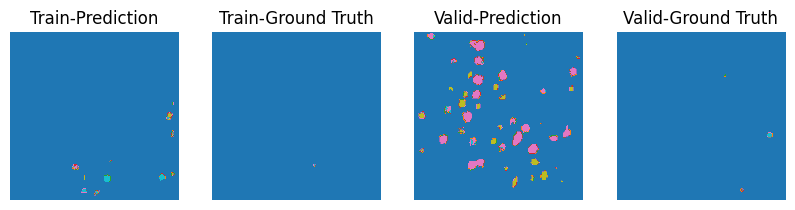

Epoch: 5, Loss: 0.14066600799560547


Valid-Epoch: 6, Loss: 0.654999655145018: 100%|██████████| 92/92 [00:03<00:00, 29.31it/s] 


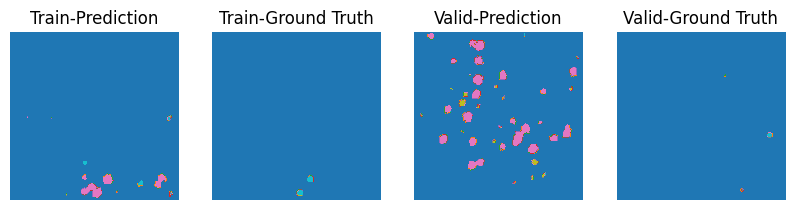

Epoch: 6, Loss: 0.11559844762086868


Valid-Epoch: 7, Loss: 0.6670870135497787: 100%|██████████| 92/92 [00:03<00:00, 29.40it/s] 


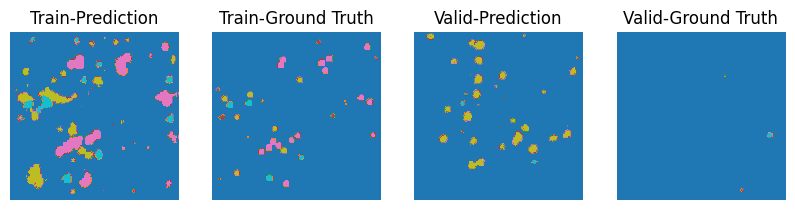

Epoch: 7, Loss: 0.09869994968175888


Valid-Epoch: 8, Loss: 0.7207099648759417: 100%|██████████| 92/92 [00:03<00:00, 29.96it/s] 


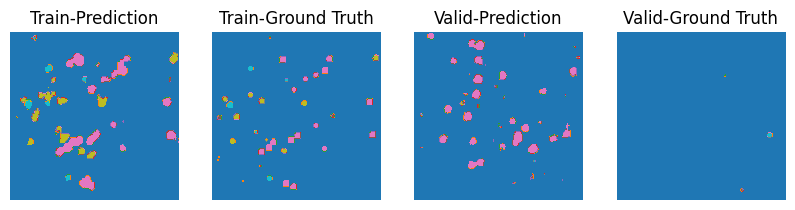

Epoch: 8, Loss: 0.07473839819431305


Valid-Epoch: 9, Loss: 0.7343357858126578: 100%|██████████| 92/92 [00:03<00:00, 27.03it/s]


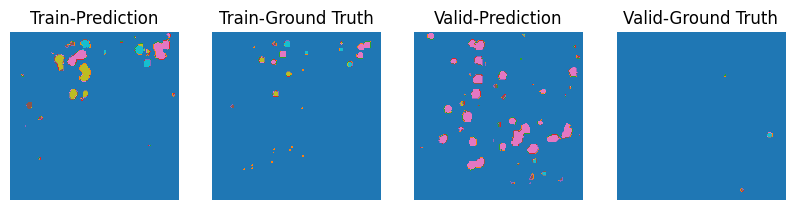

Epoch: 9, Loss: 0.05812555178999901


Valid-Epoch: 10, Loss: 0.7467209078047586: 100%|██████████| 92/92 [00:03<00:00, 29.79it/s]


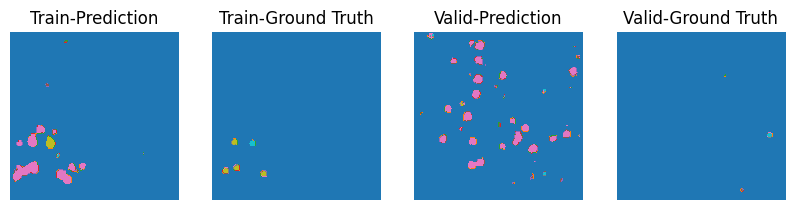

Epoch: 10, Loss: 0.05633150041103363


Valid-Epoch: 11, Loss: 0.7364983596312611: 100%|██████████| 92/92 [00:03<00:00, 28.79it/s] 


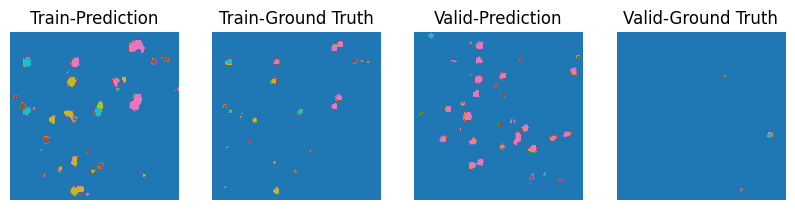

Epoch: 11, Loss: 0.04979977011680603


Valid-Epoch: 12, Loss: 0.7938939655280631: 100%|██████████| 92/92 [00:03<00:00, 30.10it/s]


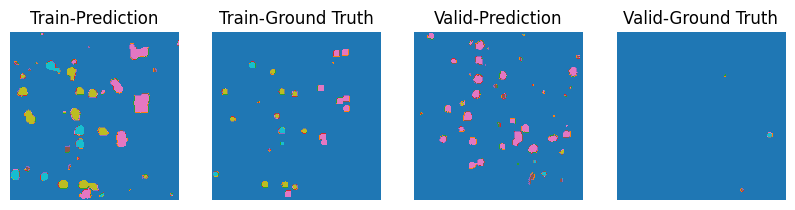

Epoch: 12, Loss: 0.0398770272731781


Valid-Epoch: 13, Loss: 0.7562981461701186: 100%|██████████| 92/92 [00:03<00:00, 29.97it/s]


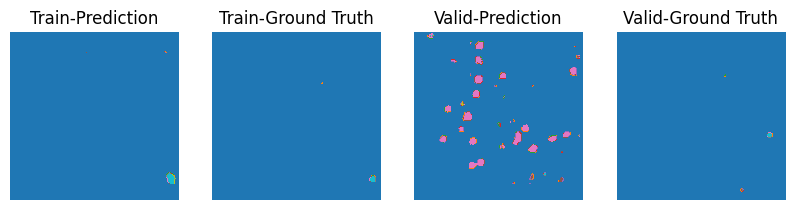

Epoch: 13, Loss: 0.036156490445137024


Valid-Epoch: 14, Loss: 0.7564415949315805: 100%|██████████| 92/92 [00:03<00:00, 30.13it/s]


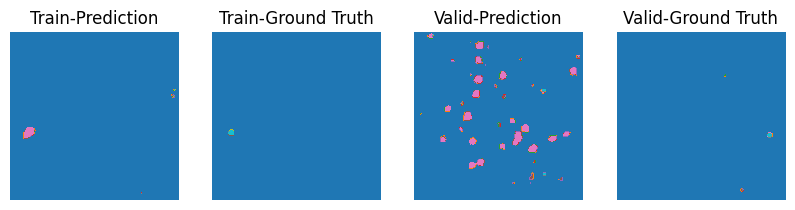

Epoch: 14, Loss: 0.032138071954250336


Valid-Epoch: 15, Loss: 0.8896763425765802: 100%|██████████| 92/92 [00:03<00:00, 30.15it/s] 


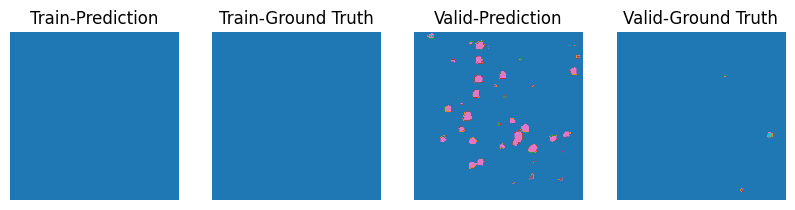

Epoch: 15, Loss: 0.029089519754052162


Valid-Epoch: 16, Loss: 0.8982888218420355: 100%|██████████| 92/92 [00:03<00:00, 29.56it/s]


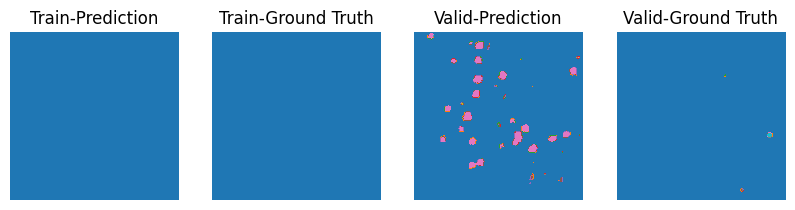

Epoch: 16, Loss: 0.027832314372062683


Valid-Epoch: 17, Loss: 0.8371732314319714: 100%|██████████| 92/92 [00:03<00:00, 30.34it/s] 


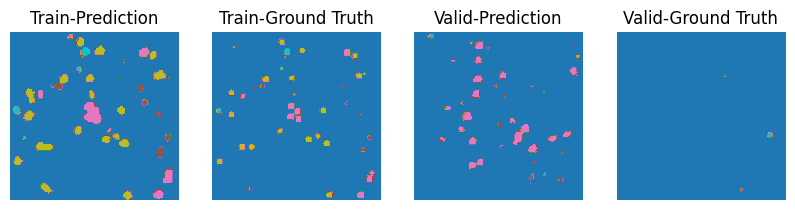

Epoch: 17, Loss: 0.024196235463023186


Valid-Epoch: 18, Loss: 0.8878426328908814: 100%|██████████| 92/92 [00:02<00:00, 30.71it/s]


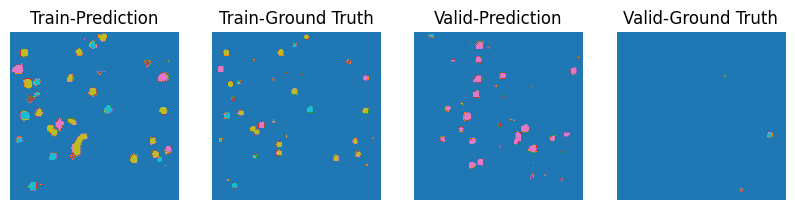

Epoch: 18, Loss: 0.021091314032673836


Valid-Epoch: 19, Loss: 0.9338088035583496: 100%|██████████| 92/92 [00:03<00:00, 28.42it/s]


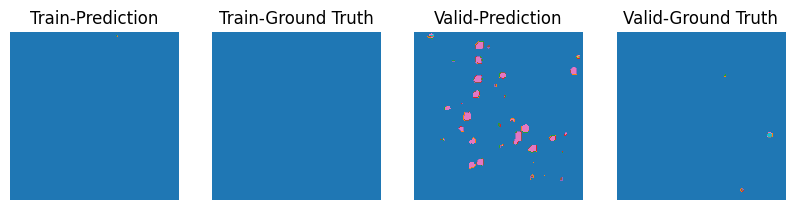

Epoch: 19, Loss: 0.020808612927794456


Valid-Epoch: 20, Loss: 0.9867659829071035: 100%|██████████| 92/92 [00:03<00:00, 30.37it/s]


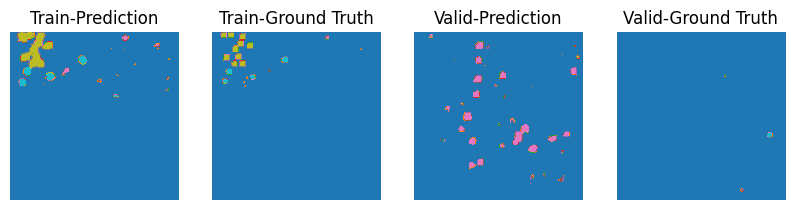

Epoch: 20, Loss: 0.0196194127202034


Valid-Epoch: 21, Loss: 0.9347355371219632: 100%|██████████| 92/92 [00:03<00:00, 29.62it/s]


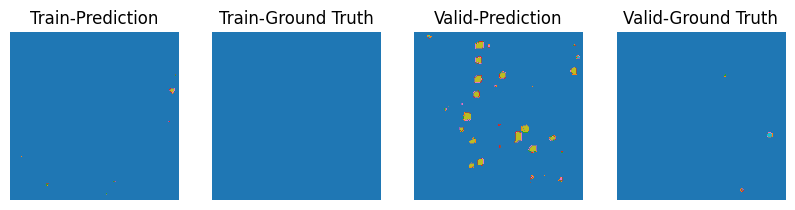

Epoch: 21, Loss: 0.019289135932922363


Valid-Epoch: 22, Loss: 0.9535186596761417: 100%|██████████| 92/92 [00:03<00:00, 29.83it/s]


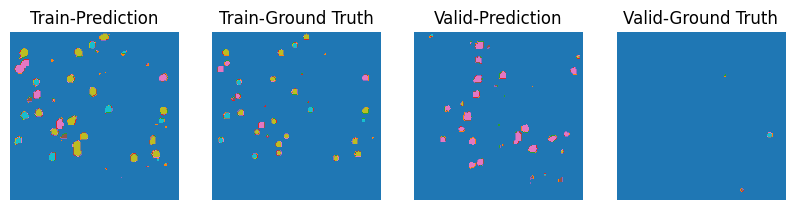

Epoch: 22, Loss: 0.01746508851647377


Valid-Epoch: 23, Loss: 1.0413012064831413: 100%|██████████| 92/92 [00:03<00:00, 29.29it/s] 


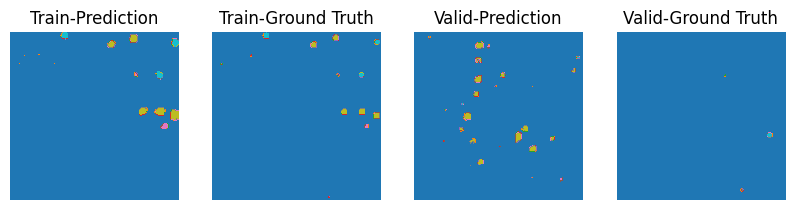

Epoch: 23, Loss: 0.0149545194581151


Valid-Epoch: 24, Loss: 1.0547523042288325: 100%|██████████| 92/92 [00:03<00:00, 30.26it/s] 


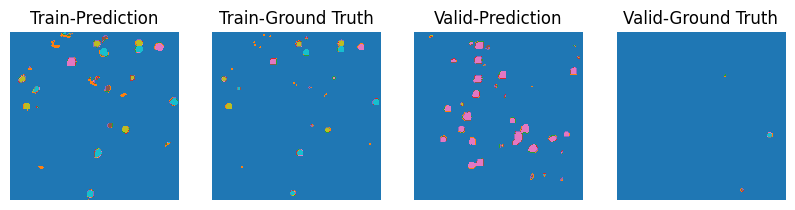

Epoch: 24, Loss: 0.014785357750952244


Valid-Epoch: 25, Loss: 1.0973319649979796: 100%|██████████| 92/92 [00:03<00:00, 28.71it/s]


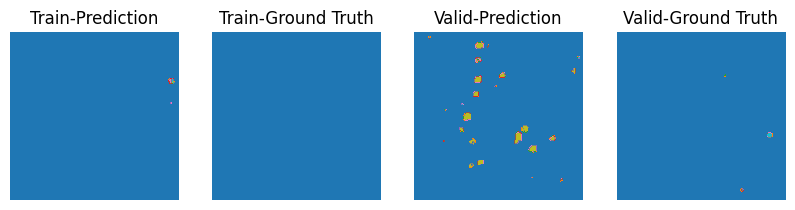

Epoch: 25, Loss: 0.013184633105993271


Valid-Epoch: 26, Loss: 1.0352651379273639: 100%|██████████| 92/92 [00:03<00:00, 29.68it/s] 


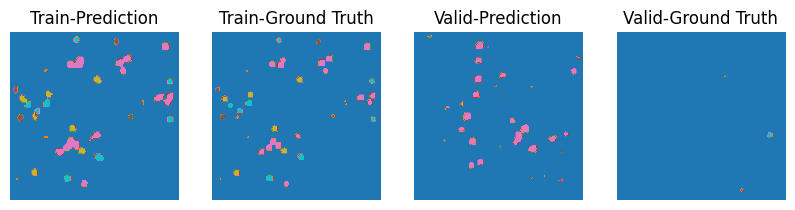

Epoch: 26, Loss: 0.01454737689346075


Valid-Epoch: 27, Loss: 1.0097289173762598: 100%|██████████| 92/92 [00:03<00:00, 28.55it/s] 


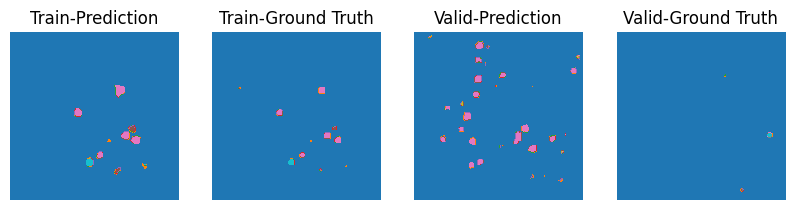

Epoch: 27, Loss: 0.01365875918418169


Valid-Epoch: 28, Loss: 1.113476486593161: 100%|██████████| 92/92 [00:03<00:00, 29.98it/s]  


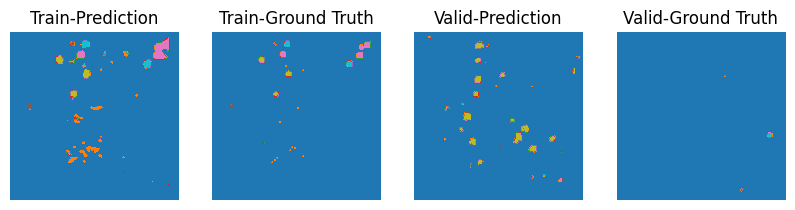

Epoch: 28, Loss: 0.012678410857915878


Valid-Epoch: 29, Loss: 1.051397816520994: 100%|██████████| 92/92 [00:02<00:00, 31.16it/s]  


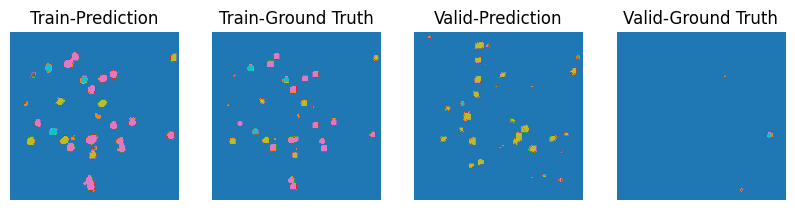

Epoch: 29, Loss: 0.010501708835363388


Valid-Epoch: 30, Loss: 1.2178916814180254: 100%|██████████| 92/92 [00:03<00:00, 28.50it/s]


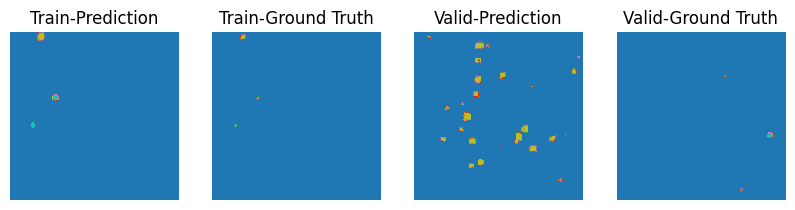

Epoch: 30, Loss: 0.010437003336846828


Valid-Epoch: 31, Loss: 1.1775848260351822: 100%|██████████| 92/92 [00:03<00:00, 28.80it/s] 


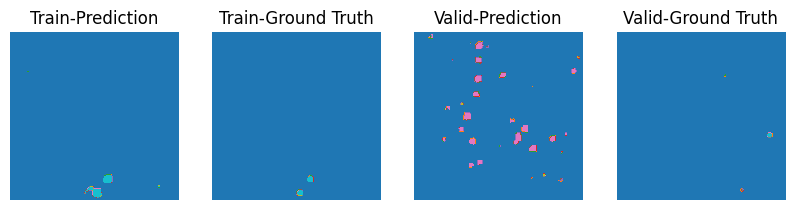

Epoch: 31, Loss: 0.011288037523627281


Valid-Epoch: 32, Loss: 1.1069737736277445: 100%|██████████| 92/92 [00:03<00:00, 30.23it/s]


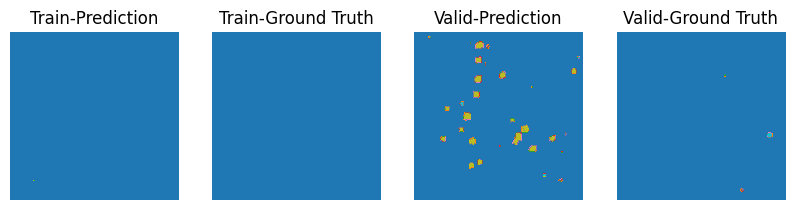

Epoch: 32, Loss: 0.010492546483874321


Valid-Epoch: 33, Loss: 1.118104878524521: 100%|██████████| 92/92 [00:03<00:00, 30.18it/s]  


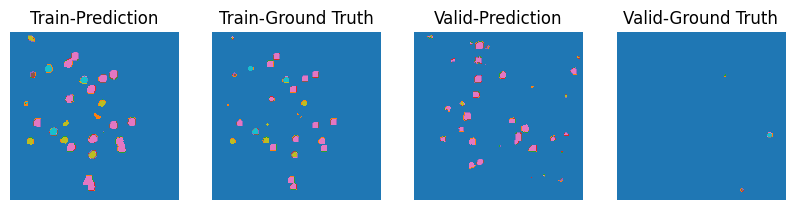

Epoch: 33, Loss: 0.009336930699646473


Valid-Epoch: 34, Loss: 1.2699013219376944: 100%|██████████| 92/92 [00:03<00:00, 27.69it/s]


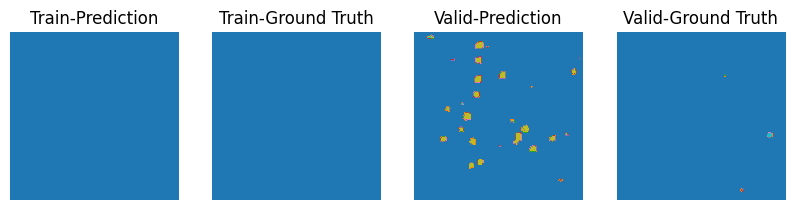

Epoch: 34, Loss: 0.006507992744445801


Valid-Epoch: 35, Loss: 1.1696461964773177: 100%|██████████| 92/92 [00:03<00:00, 29.09it/s] 


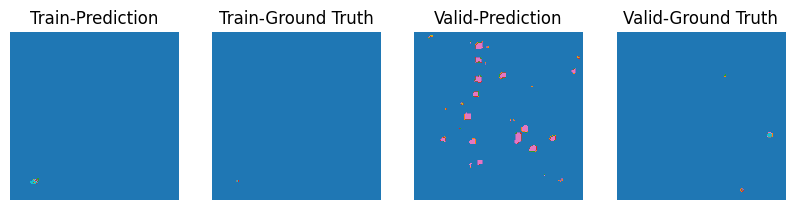

Epoch: 35, Loss: 0.007201981730759144


Valid-Epoch: 36, Loss: 1.260100520494313: 100%|██████████| 92/92 [00:03<00:00, 30.07it/s] 


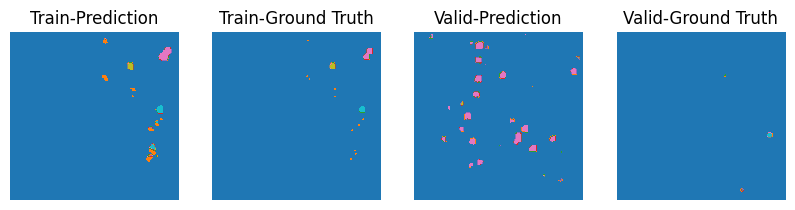

Epoch: 36, Loss: 0.008285967633128166


Valid-Epoch: 37, Loss: 1.2491480381501352: 100%|██████████| 92/92 [00:03<00:00, 30.04it/s] 


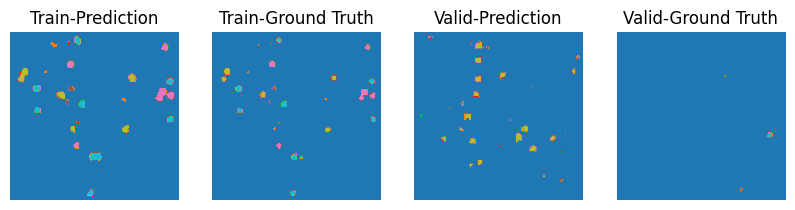

Epoch: 37, Loss: 0.007336471229791641


Valid-Epoch: 38, Loss: 1.3230520500548426: 100%|██████████| 92/92 [00:02<00:00, 30.72it/s]


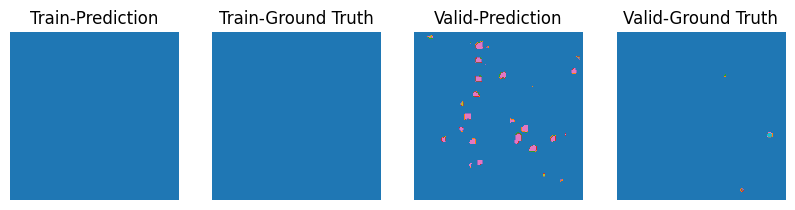

Epoch: 38, Loss: 0.007092906627804041


Valid-Epoch: 39, Loss: 1.2723006364869196: 100%|██████████| 92/92 [00:03<00:00, 29.37it/s] 


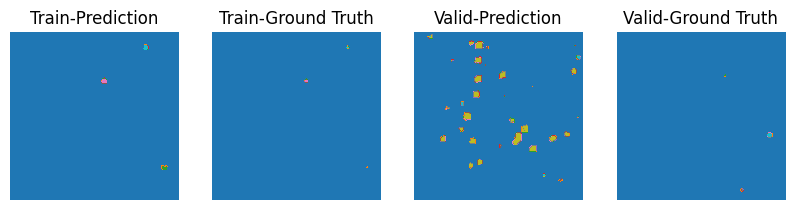

Epoch: 39, Loss: 0.008318666368722916


Valid-Epoch: 40, Loss: 1.2933547865427302: 100%|██████████| 92/92 [00:02<00:00, 30.85it/s]


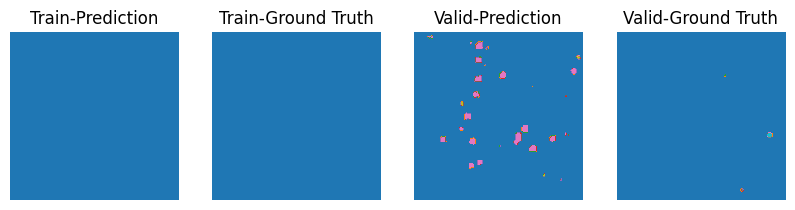

Epoch: 40, Loss: 0.007776396814733744


Valid-Epoch: 41, Loss: 1.3904910086775604: 100%|██████████| 92/92 [00:03<00:00, 28.11it/s] 


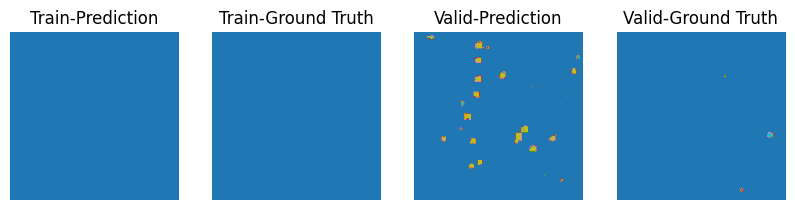

Epoch: 41, Loss: 0.007102788891643286


Valid-Epoch: 42, Loss: 1.4741011632899956: 100%|██████████| 92/92 [00:02<00:00, 30.78it/s]


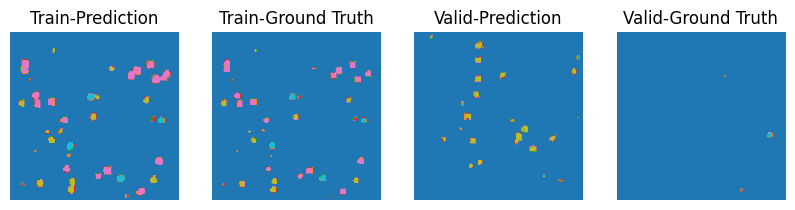

Epoch: 42, Loss: 0.006386381573975086


Valid-Epoch: 43, Loss: 1.4621547247414761: 100%|██████████| 92/92 [00:03<00:00, 30.57it/s]


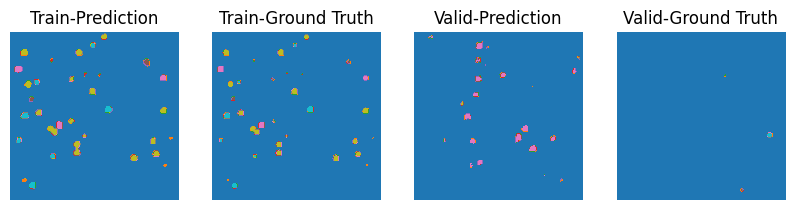

Epoch: 43, Loss: 0.007860301993787289


Valid-Epoch: 44, Loss: 1.5328089278748096: 100%|██████████| 92/92 [00:03<00:00, 30.46it/s] 


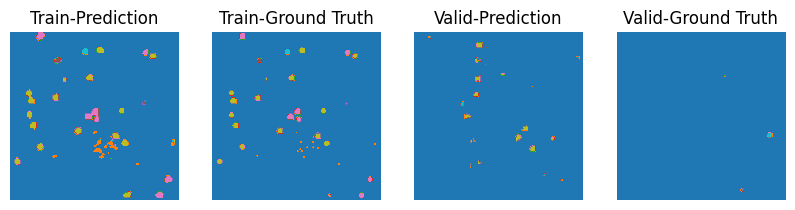

Epoch: 44, Loss: 0.005033882800489664


Valid-Epoch: 45, Loss: 1.4685934110235868: 100%|██████████| 92/92 [00:03<00:00, 30.31it/s]


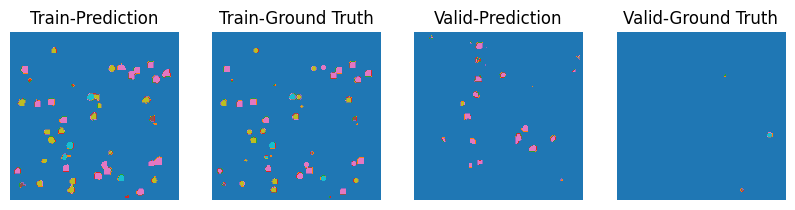

Epoch: 45, Loss: 0.005519685335457325


Valid-Epoch: 46, Loss: 1.4162006768924387: 100%|██████████| 92/92 [00:03<00:00, 27.51it/s]


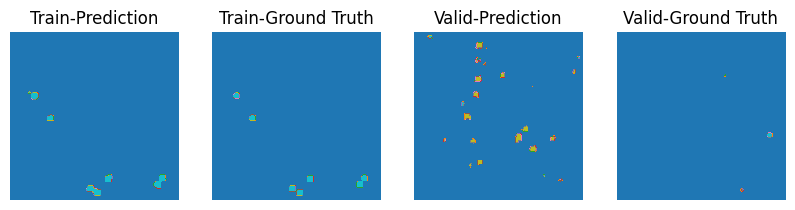

Epoch: 46, Loss: 0.004665822256356478


Valid-Epoch: 47, Loss: 1.3515758531967825: 100%|██████████| 92/92 [00:03<00:00, 29.84it/s] 


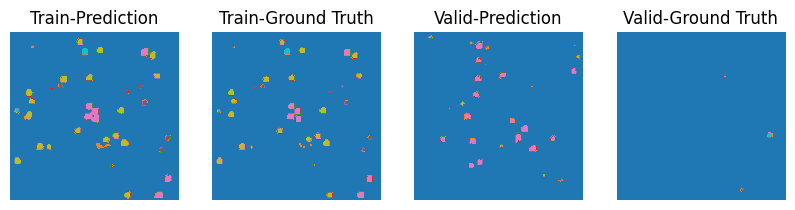

Epoch: 47, Loss: 0.004535072483122349


Valid-Epoch: 48, Loss: 1.4928079557848042: 100%|██████████| 92/92 [00:03<00:00, 27.31it/s] 


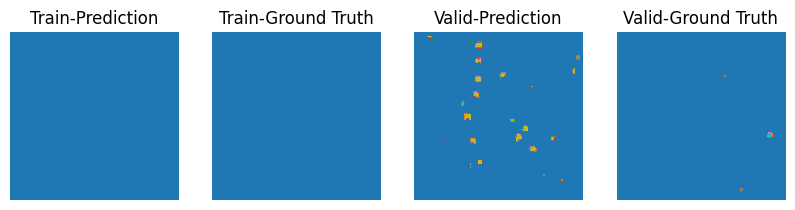

Epoch: 48, Loss: 0.004877349827438593


Valid-Epoch: 49, Loss: 1.5415178663831244: 100%|██████████| 92/92 [00:03<00:00, 30.01it/s] 


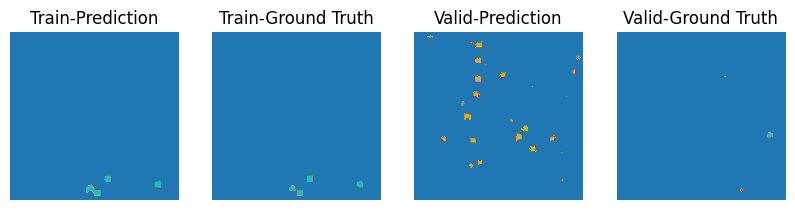

Epoch: 49, Loss: 0.005076459608972073


Valid-Epoch: 50, Loss: 1.386342733830173: 100%|██████████| 92/92 [00:03<00:00, 28.45it/s] 


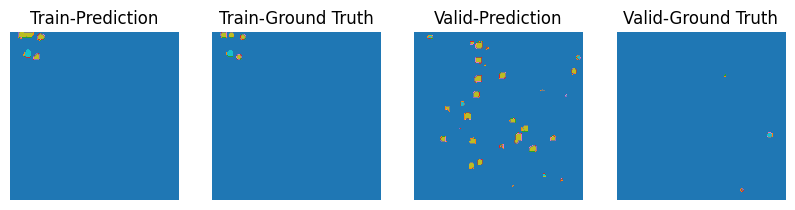

Epoch: 50, Loss: 0.0065880948677659035


Valid-Epoch: 51, Loss: 1.4359766002314205: 100%|██████████| 92/92 [00:03<00:00, 29.61it/s] 


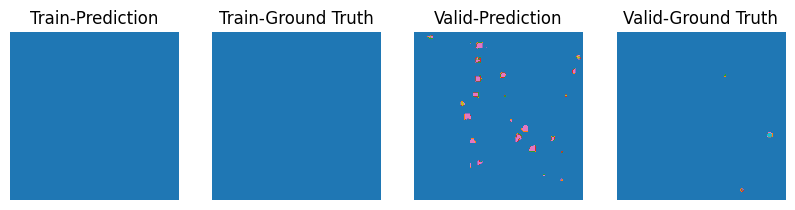

Epoch: 51, Loss: 0.004516750108450651


Valid-Epoch: 52, Loss: 1.5148914387555914: 100%|██████████| 92/92 [00:03<00:00, 28.13it/s] 


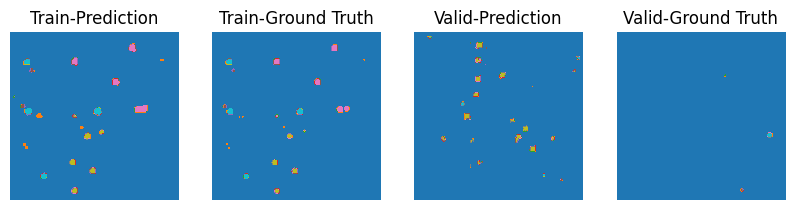

Epoch: 52, Loss: 0.0036164161283522844


Valid-Epoch: 53, Loss: 1.5026646497198786: 100%|██████████| 92/92 [00:03<00:00, 30.17it/s] 


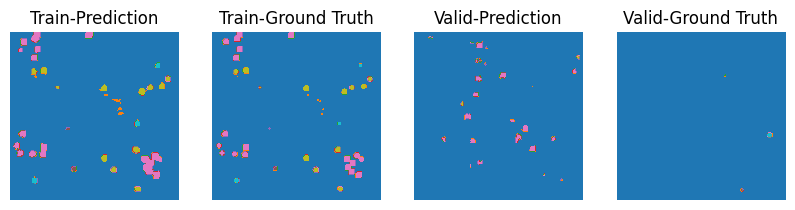

Epoch: 53, Loss: 0.004912366159260273


Valid-Epoch: 54, Loss: 1.5451231009590074: 100%|██████████| 92/92 [00:02<00:00, 30.83it/s] 


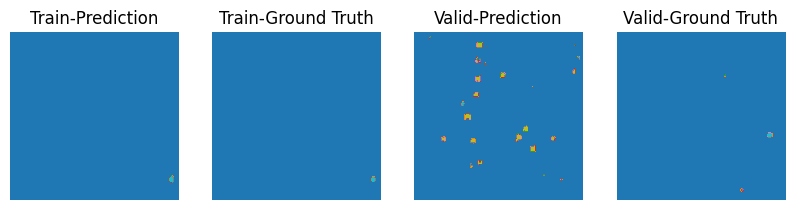

Epoch: 54, Loss: 0.00394181115552783


Valid-Epoch: 55, Loss: 1.496460369965264: 100%|██████████| 92/92 [00:03<00:00, 26.29it/s] 


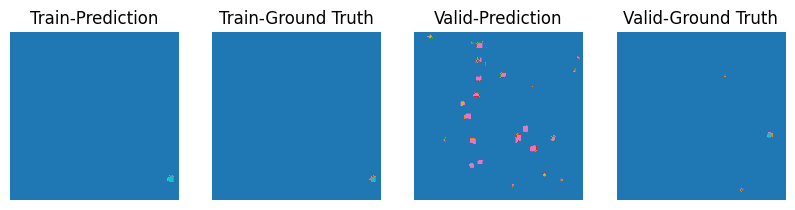

Epoch: 55, Loss: 0.0030859962571412325


Valid-Epoch: 56, Loss: 1.4928472120967775: 100%|██████████| 92/92 [00:03<00:00, 28.33it/s]


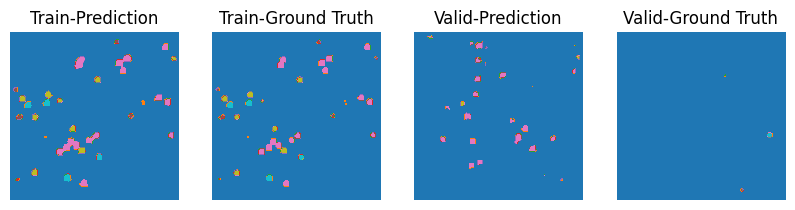

Epoch: 56, Loss: 0.0033646654337644577


Valid-Epoch: 57, Loss: 1.4454312866880132: 100%|██████████| 92/92 [00:03<00:00, 25.29it/s] 


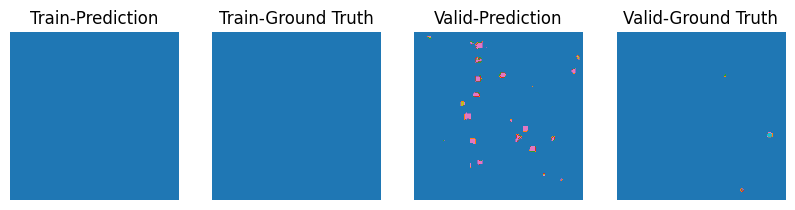

Epoch: 57, Loss: 0.0032531404867768288


Valid-Epoch: 58, Loss: 1.4495008023982139: 100%|██████████| 92/92 [00:03<00:00, 30.64it/s] 


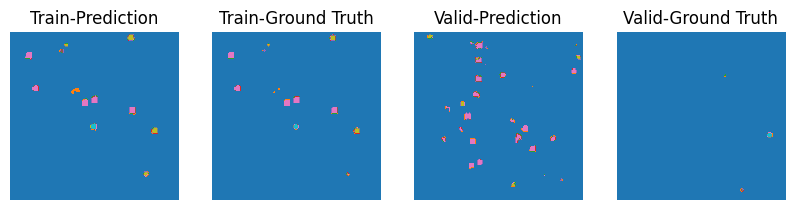

Epoch: 58, Loss: 0.004189181141555309


Valid-Epoch: 59, Loss: 1.5610659903335466: 100%|██████████| 92/92 [00:03<00:00, 29.47it/s] 


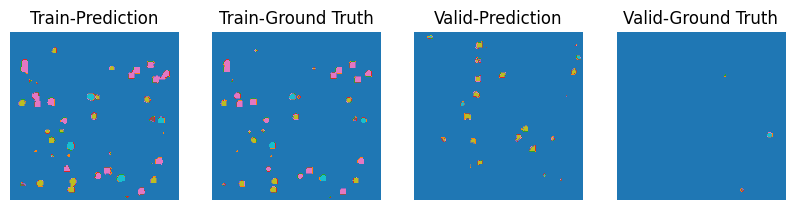

Epoch: 59, Loss: 0.004249972756952047


Valid-Epoch: 60, Loss: 1.4517533518082928: 100%|██████████| 92/92 [00:03<00:00, 30.66it/s] 


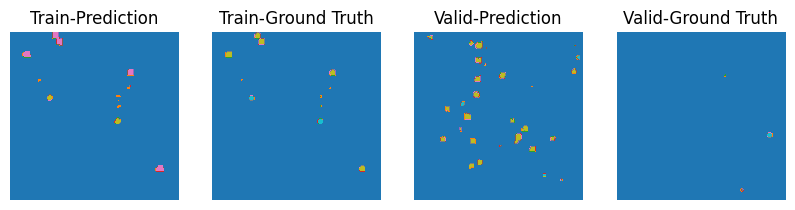

Epoch: 60, Loss: 0.005608756560832262


Valid-Epoch: 61, Loss: 1.6437820120076851: 100%|██████████| 92/92 [00:03<00:00, 27.57it/s] 


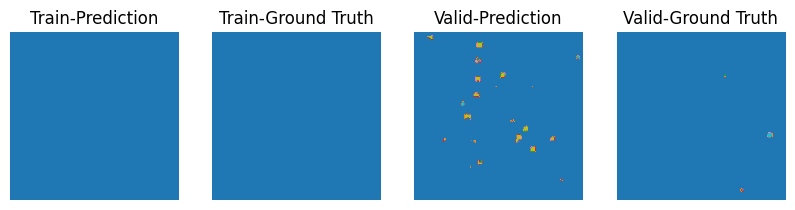

Epoch: 61, Loss: 0.0018606696976348758


Valid-Epoch: 62, Loss: 1.557511650640821: 100%|██████████| 92/92 [00:03<00:00, 28.81it/s]  


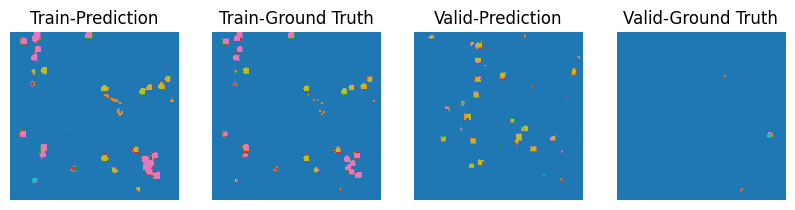

Epoch: 62, Loss: 0.004386012442409992


Valid-Epoch: 63, Loss: 1.490968958001442: 100%|██████████| 92/92 [00:03<00:00, 29.79it/s] 


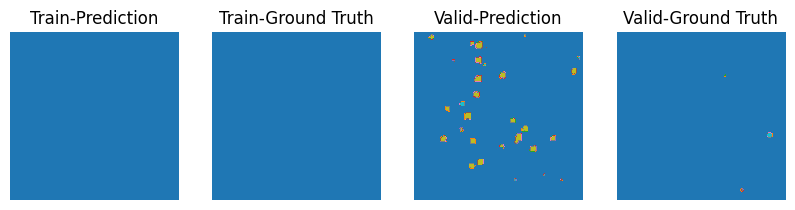

Epoch: 63, Loss: 0.004896476864814758


Valid-Epoch: 64, Loss: 1.548365474236957: 100%|██████████| 92/92 [00:03<00:00, 30.48it/s]  


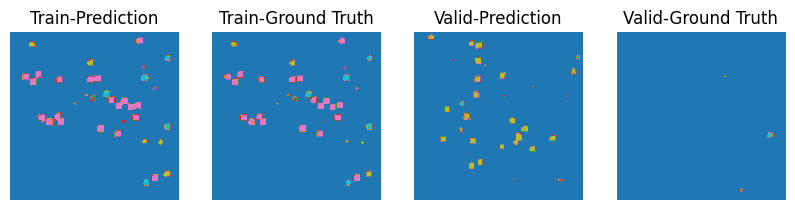

Epoch: 64, Loss: 0.0035955903586000204


Valid-Epoch: 65, Loss: 1.5668667637219187: 100%|██████████| 92/92 [00:03<00:00, 30.23it/s]


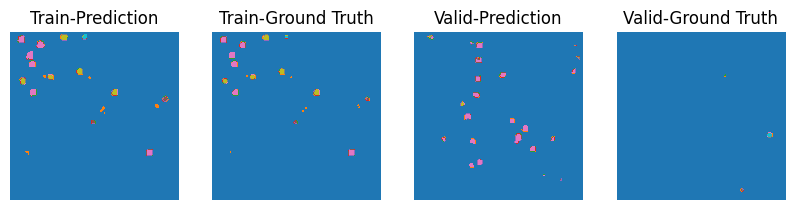

Epoch: 65, Loss: 0.0028887074440717697


Valid-Epoch: 66, Loss: 1.5272399196742892: 100%|██████████| 92/92 [00:03<00:00, 30.32it/s] 


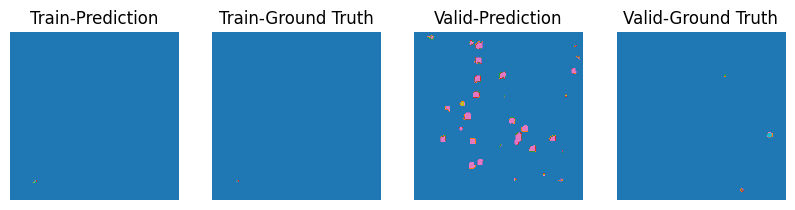

Epoch: 66, Loss: 0.0041201370768249035


Valid-Epoch: 67, Loss: 1.619408502769859: 100%|██████████| 92/92 [00:02<00:00, 31.05it/s]  


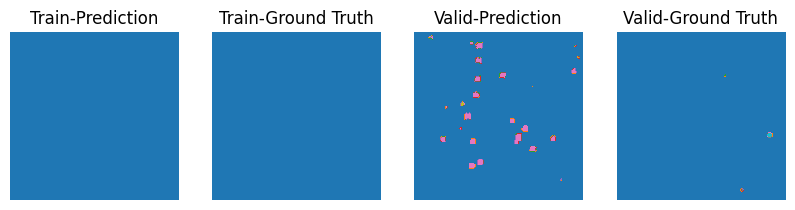

Epoch: 67, Loss: 0.0028342336881905794


Valid-Epoch: 68, Loss: 1.6700548774767767: 100%|██████████| 92/92 [00:02<00:00, 31.27it/s] 


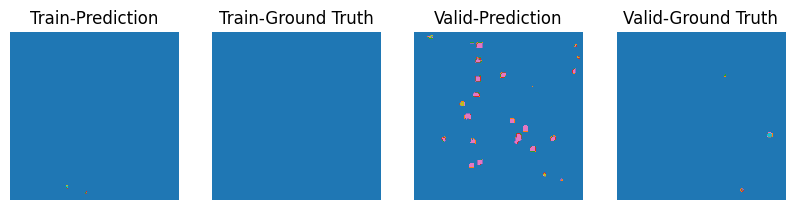

Epoch: 68, Loss: 0.0033651897683739662


Valid-Epoch: 69, Loss: 1.6287312737941924: 100%|██████████| 92/92 [00:03<00:00, 28.57it/s] 


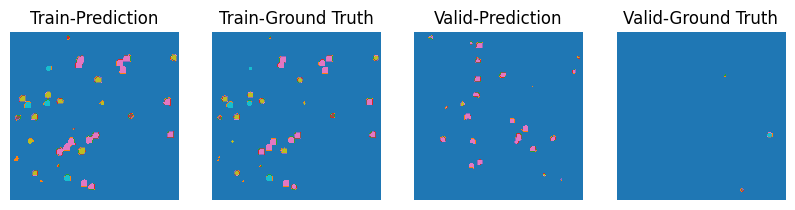

Epoch: 69, Loss: 0.0028350495267659426


Valid-Epoch: 70, Loss: 1.7486902234605108: 100%|██████████| 92/92 [00:03<00:00, 29.04it/s] 


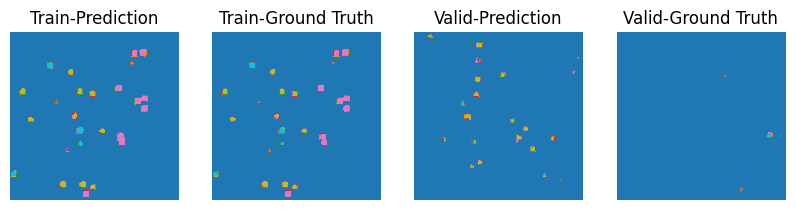

Epoch: 70, Loss: 0.0032732642721384764


Valid-Epoch: 71, Loss: 1.628487626388011: 100%|██████████| 92/92 [00:03<00:00, 28.24it/s]  


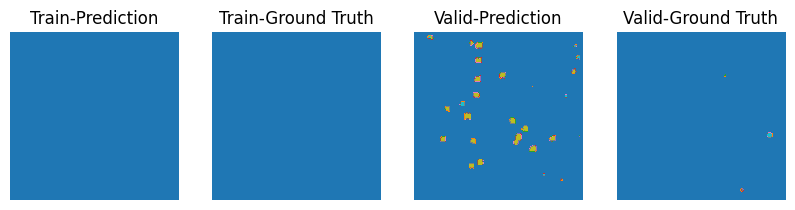

Epoch: 71, Loss: 0.004697747528553009


Valid-Epoch: 72, Loss: 1.590666122672543: 100%|██████████| 92/92 [00:03<00:00, 29.73it/s]  


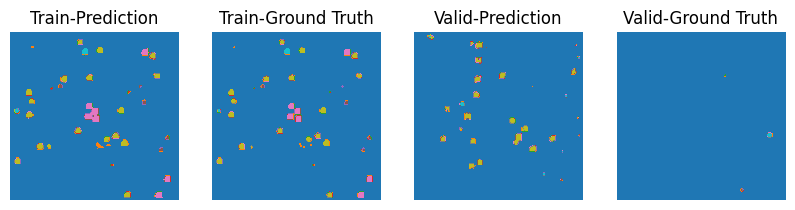

Epoch: 72, Loss: 0.005135771818459034


Valid-Epoch: 73, Loss: 1.6616210499537967: 100%|██████████| 92/92 [00:03<00:00, 29.86it/s]


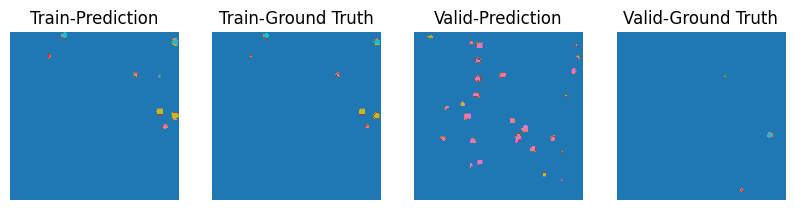

Epoch: 73, Loss: 0.0051697613671422005


Valid-Epoch: 74, Loss: 1.7340605811610736: 100%|██████████| 92/92 [00:03<00:00, 29.49it/s] 


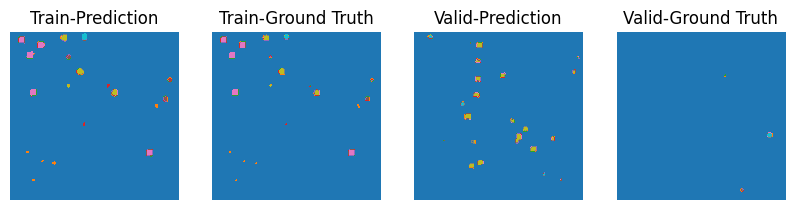

Epoch: 74, Loss: 0.0039034676738083363


Valid-Epoch: 75, Loss: 1.6973127483595263: 100%|██████████| 92/92 [00:03<00:00, 29.13it/s] 


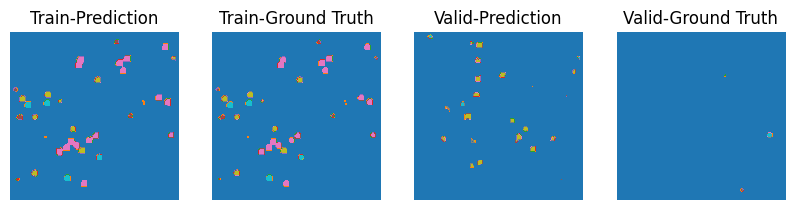

Epoch: 75, Loss: 0.0021560180466622114


Valid-Epoch: 76, Loss: 1.7037976518179716: 100%|██████████| 92/92 [00:03<00:00, 29.83it/s] 


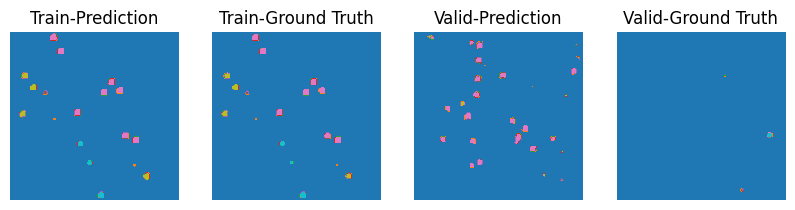

Epoch: 76, Loss: 0.005327945575118065


Valid-Epoch: 77, Loss: 1.7778194331483024: 100%|██████████| 92/92 [00:03<00:00, 30.24it/s]


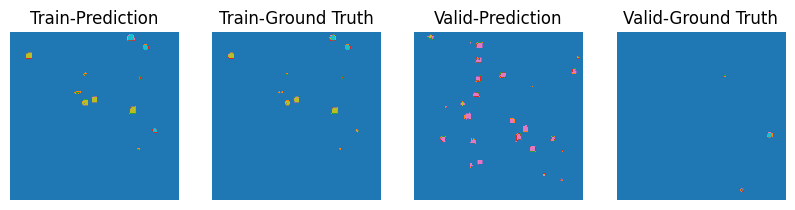

Epoch: 77, Loss: 0.004184703808277845


Valid-Epoch: 78, Loss: 1.717535241989105: 100%|██████████| 92/92 [00:03<00:00, 29.41it/s] 


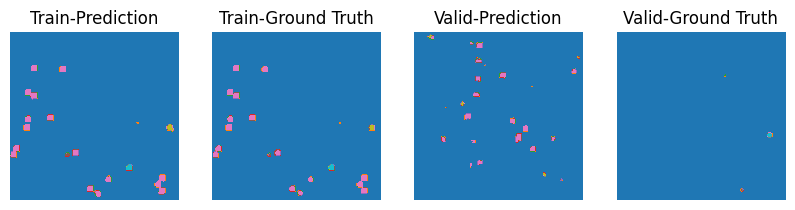

Epoch: 78, Loss: 0.005523658823221922


Valid-Epoch: 79, Loss: 1.746045089197097: 100%|██████████| 92/92 [00:03<00:00, 30.22it/s]  


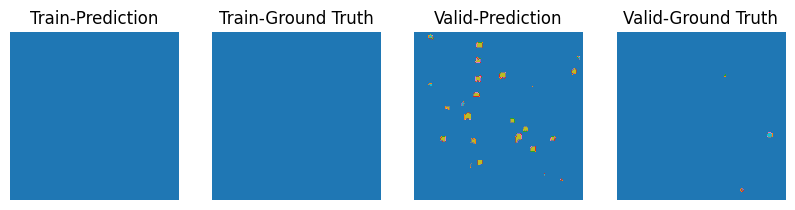

Epoch: 79, Loss: 0.0020244140177965164


Valid-Epoch: 80, Loss: 1.7572574676704118: 100%|██████████| 92/92 [00:03<00:00, 30.10it/s]


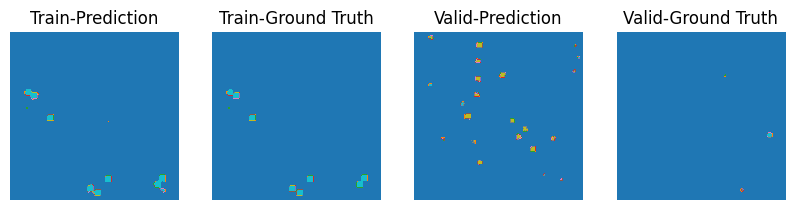

Epoch: 80, Loss: 0.0016985927941277623


Valid-Epoch: 81, Loss: 1.536325459810146: 100%|██████████| 92/92 [00:03<00:00, 30.28it/s]  


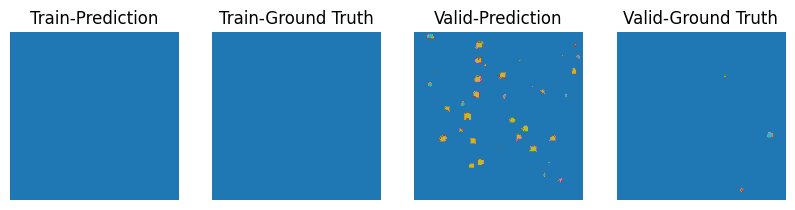

Epoch: 81, Loss: 0.007043392863124609


Valid-Epoch: 82, Loss: 1.5796903022976196: 100%|██████████| 92/92 [00:03<00:00, 29.99it/s] 


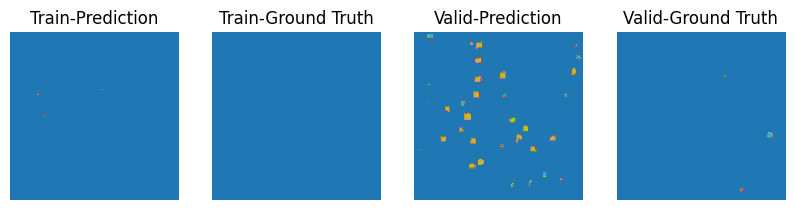

Epoch: 82, Loss: 0.0041303811594843864


Valid-Epoch: 83, Loss: 1.7121778047477836: 100%|██████████| 92/92 [00:03<00:00, 29.19it/s] 


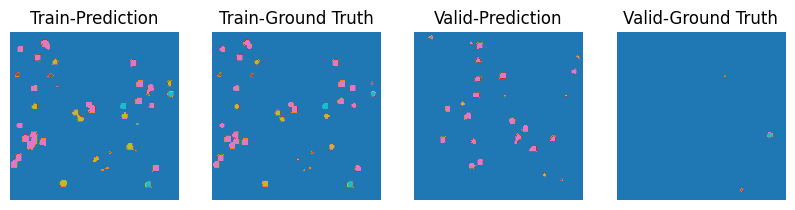

Epoch: 83, Loss: 0.003055838868021965


Valid-Epoch: 84, Loss: 1.7618896412383511: 100%|██████████| 92/92 [00:03<00:00, 30.62it/s]


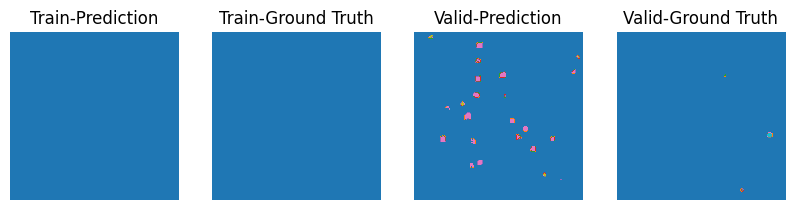

Epoch: 84, Loss: 0.004622137639671564


Valid-Epoch: 85, Loss: 1.6798839772875553: 100%|██████████| 92/92 [00:03<00:00, 27.26it/s]


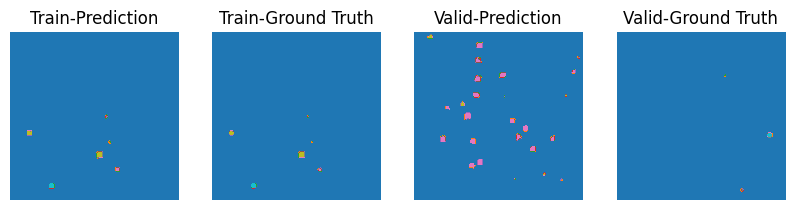

Epoch: 85, Loss: 0.005799749866127968


Valid-Epoch: 86, Loss: 1.818186353308746: 100%|██████████| 92/92 [00:03<00:00, 29.59it/s] 


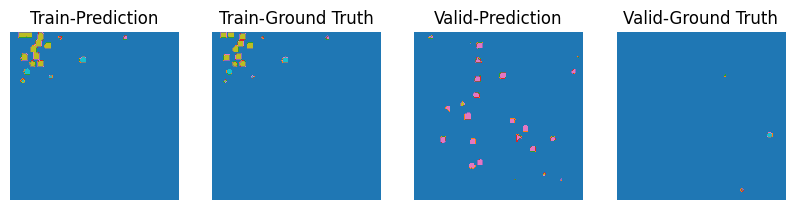

Epoch: 86, Loss: 0.003604005090892315


Valid-Epoch: 87, Loss: 1.7396489245356466: 100%|██████████| 92/92 [00:02<00:00, 30.74it/s] 


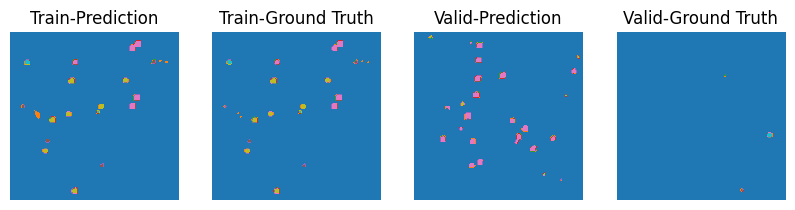

Epoch: 87, Loss: 0.004625427536666393


Valid-Epoch: 88, Loss: 1.8828344554703622: 100%|██████████| 92/92 [00:02<00:00, 31.28it/s]


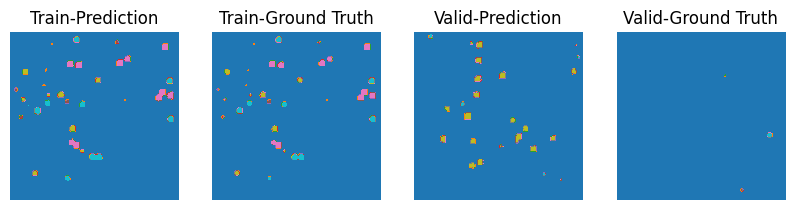

Epoch: 88, Loss: 0.003987451083958149


Valid-Epoch: 89, Loss: 1.8403922349762465: 100%|██████████| 92/92 [00:02<00:00, 31.54it/s]


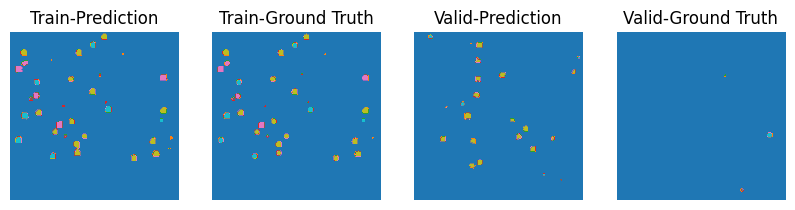

Epoch: 89, Loss: 0.0016636827494949102


Valid-Epoch: 90, Loss: 1.8998536041744165: 100%|██████████| 92/92 [00:02<00:00, 31.77it/s] 


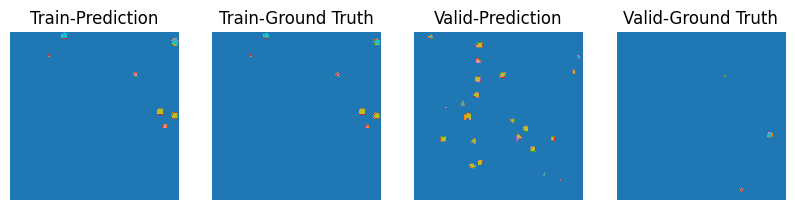

Epoch: 90, Loss: 0.0033082938753068447


Valid-Epoch: 91, Loss: 1.9275502808772929: 100%|██████████| 92/92 [00:03<00:00, 30.53it/s] 


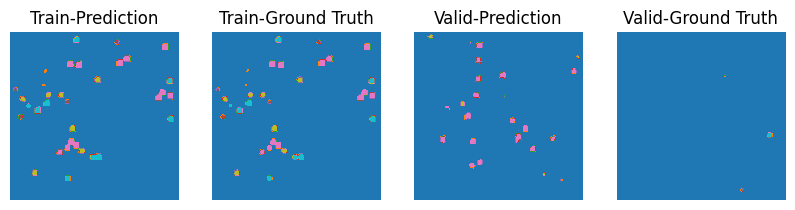

Epoch: 91, Loss: 0.0025121390353888273


Valid-Epoch: 92, Loss: 1.779075804215213: 100%|██████████| 92/92 [00:03<00:00, 29.10it/s] 


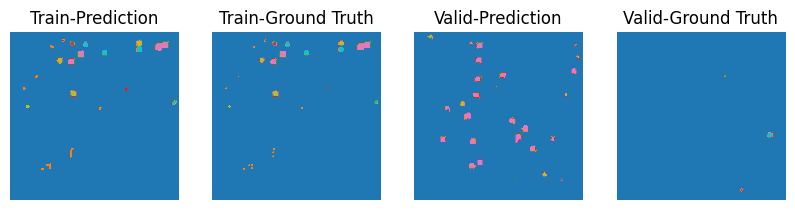

Epoch: 92, Loss: 0.004530408885329962


Valid-Epoch: 93, Loss: 1.9643897765164855: 100%|██████████| 92/92 [00:03<00:00, 29.68it/s] 


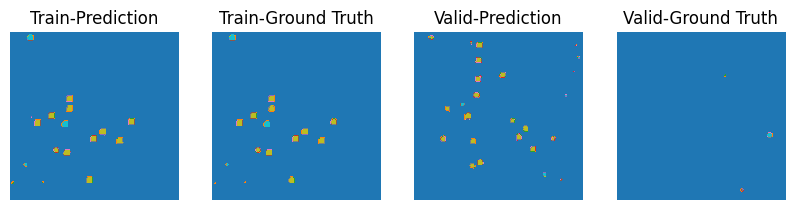

Epoch: 93, Loss: 0.002826015930622816


Valid-Epoch: 94, Loss: 1.7554584610403727: 100%|██████████| 92/92 [00:03<00:00, 27.28it/s] 


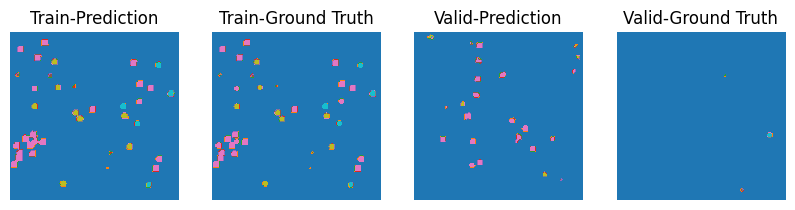

Epoch: 94, Loss: 0.002969990484416485


Valid-Epoch: 95, Loss: 1.9732694088566147: 100%|██████████| 92/92 [00:03<00:00, 29.32it/s] 


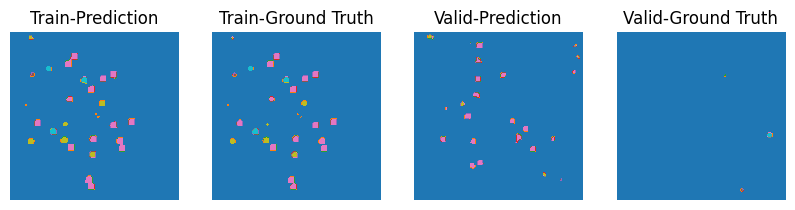

Epoch: 95, Loss: 0.0038635325618088245


Valid-Epoch: 96, Loss: 1.847287804539361: 100%|██████████| 92/92 [00:03<00:00, 28.58it/s] 


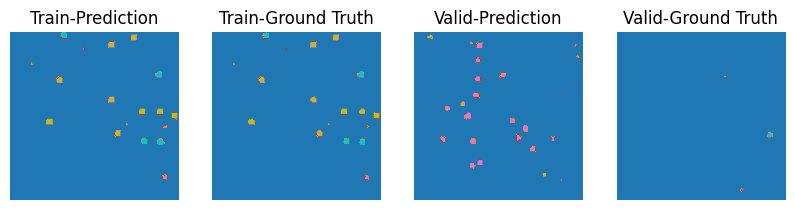

Epoch: 96, Loss: 0.004276617895811796


Valid-Epoch: 97, Loss: 1.9068549491952898: 100%|██████████| 92/92 [00:03<00:00, 29.64it/s] 


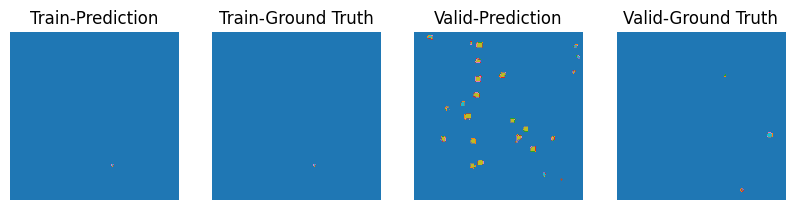

Epoch: 97, Loss: 0.0030887715984135866


Valid-Epoch: 98, Loss: 2.0790033805489023: 100%|██████████| 92/92 [00:03<00:00, 28.38it/s]


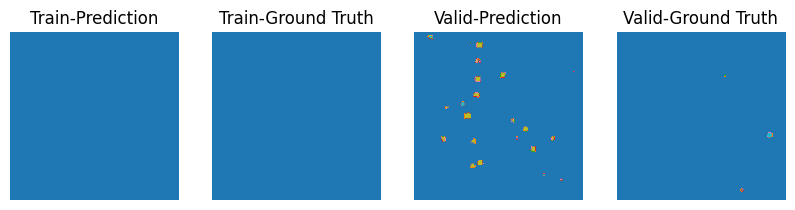

Epoch: 98, Loss: 0.0012127867667004466


Valid-Epoch: 99, Loss: 1.9983532582118642: 100%|██████████| 92/92 [00:03<00:00, 28.06it/s]


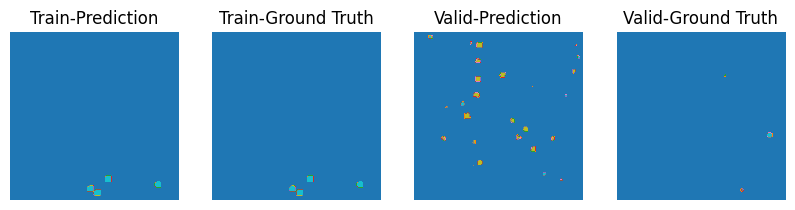

Epoch: 99, Loss: 0.002611095318570733


In [6]:
model = UNet_2D().to("cuda")
model.eval()


def save_images(
    train_pred_tomogram,
    train_gt_tomogram,
    valid_pred_tomogram,
    valid_gt_tomogram,
    save_dir="images",
    epoch=0,
):
    import os

    train_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "train")
    valid_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "valid")
    os.makedirs(train_save_dir, exist_ok=True)
    os.makedirs(valid_save_dir, exist_ok=True)
    # 可視化
    for i in range(len(train_pred_tomogram)):
        train_pred = train_pred_tomogram[i].argmax(1).squeeze(0)
        train_gt = train_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(train_pred, cmap="tab10")
        ax.set_title("Train-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(train_gt, cmap="tab10")
        ax.set_title("Train-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(train_save_dir, f"train_{i}.png"))
        plt.close()

    for i in range(len(valid_pred_tomogram)):
        valid_pred = valid_pred_tomogram[i].argmax(1).squeeze(0)
        valid_gt = valid_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(valid_pred, cmap="tab10")
        ax.set_title("Valid-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(valid_gt, cmap="tab10")
        ax.set_title("Valid-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(valid_save_dir, f"valid_{i}.png"))
        plt.close()


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_loss = np.inf
batch_size = 10

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = []
    train_gt_tomogram = []
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"].long()

        for i in range(batch_size, tomogram.shape[1], batch_size):
            optimizer.zero_grad()
            from_, to_ = 0, tomogram.shape[1]
            random_index = random.sample(range(from_, to_), batch_size)
            input_ = tomogram[:, random_index]
            input_ = input_.permute(1, 0, 2, 3)
            gt = segmentation_map[:, random_index].squeeze()
            input_ = input_.to("cuda")
            gt = gt.to("cuda")
            output = model(input_)
            loss = criterion(output, gt)

            # for i in range(batch_size):
            #     ic(output[i].shape, gt[i].shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            #     loss = criterion(output[i].unsqueeze(0), gt[i].unsqueeze(0))
            #     loss.backward()
            #     optimizer.step()

            #     train_loss.append(loss.item())
            #     tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            #     tq.update(1)

            #     train_pred_tomogram.append(output.cpu().detach().numpy())
            #     train_gt_tomogram.append(gt.cpu().detach().numpy())

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            for i in range(batch_size):
                train_pred_tomogram.append(output[i].cpu().detach().numpy())
                train_gt_tomogram.append(gt[i].cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    valid_pred_tomogram = []
    valid_gt_tomogram = []
    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram.append(output.cpu().detach().numpy())
            valid_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    if np.mean(valid_loss) < best_loss:
        best_loss = np.mean(valid_loss)
        best_model = model
        torch.save(best_model.state_dict(), "best_model.pth")

    # 可視化
    index = 50

    # 2つの画像を並べて表示
    plt.figure(figsize=(10, 5))

    # 2つの画像を並べて表示
    ax = plt.subplot(1, 4, 1)
    ax.imshow(train_pred_tomogram[index].argmax(0), cmap="tab10")
    ax.set_title("Train-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(train_gt_tomogram[index], cmap="tab10")
    ax.set_title("Train-Ground Truth")
    ax.axis("off")

    ax = plt.subplot(1, 4, 3)
    ax.imshow(valid_pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
    ax.set_title("Valid-Prediction")
    ax.axis("off")

    ax = plt.subplot(1, 4, 4)
    ax.imshow(valid_gt_tomogram[index].squeeze(0), cmap="tab10")
    ax.set_title("Valid-Ground Truth")
    ax.axis("off")

    plt.show()

    # save_images(
    #     train_gt_tomogram=train_gt_tomogram,
    #     train_pred_tomogram=train_pred_tomogram,
    #     valid_gt_tomogram=valid_gt_tomogram,
    #     valid_pred_tomogram=valid_pred_tomogram,
    #     save_dir="images",
    #     epoch=epoch,
    # )

    print(f"Epoch: {epoch}, Loss: {loss.item()}")